To-Dos:
- [ ] Create separate preprocessing piplines both including and excluding features that were used to calculate new features
- [ ] Apply reduced preprocessing to Ridge and KNN; full preprocessing to tree-based models

# Project Description

# Establishing professor's baseline

In [4]:
## Import all needed libraries
import numpy as np
import pandas as pd
import json
import logging
import zipfile
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error

## Initiate common random state
r_state = 123


In [5]:
# Set up logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# Log the start of the process
logging.info("Reading train and test files")

# Read the full dataset
data = pd.read_json("train.json", orient='records')
test = pd.read_json("test.json", orient='records')

# Fill missing 'rooms' where room_type is private/shared/hotel with 1
room_fill_conditions = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room'])

# Only apply the fill where 'rooms' is NaN and room type is a single room type
data.loc[room_fill_conditions & data['rooms'].isna(), 'rooms'] = 1

# Split the full data into train and validation BEFORE any transformation
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)

drop_cols = ['host', 'name', 'facilities', #'guests', 
             'revenue']  # add others like 'beds' or 'cancellation' if needed
label = 'revenue'

X_train = raw_train.drop(columns=drop_cols)
y_train = raw_train[label]  # Do not transform yet

X_valid = raw_valid.drop(columns=drop_cols)
y_valid = raw_valid[label]


2025-05-11 12:54:24,159 - INFO - Reading train and test files


In [6]:
print(X_train.shape)
print(X_valid.shape)

(10178, 12)
(5090, 12)


# Environment set-up & data import

In [8]:
# --- Core ---
import pandas as pd
import numpy as np
import logging

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn: Preprocessing ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# --- Scikit-learn: Models ---
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor
)

# --- Scikit-learn: Metrics ---
from sklearn.metrics import mean_absolute_error

# --- Other ML Libraries ---
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# --- Optional: Feature Engineering Tools ---
# from sklearn.cluster import KMeans
# from geopy.distance import geodesic

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')


2025-05-11 12:54:24,426 - DEBUG - matplotlib data path: C:\Users\chels\anaconda3\Lib\site-packages\matplotlib\mpl-data
2025-05-11 12:54:24,430 - DEBUG - CONFIGDIR=C:\Users\chels\.matplotlib
2025-05-11 12:54:24,432 - DEBUG - interactive is False
2025-05-11 12:54:24,433 - DEBUG - platform is win32
2025-05-11 12:54:24,540 - DEBUG - CACHEDIR=C:\Users\chels\.matplotlib
2025-05-11 12:54:24,543 - DEBUG - Using fontManager instance from C:\Users\chels\.matplotlib\fontlist-v330.json
2025-05-11 12:54:24,791 - DEBUG - deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-05-11 12:54:24,793 - DEBUG - deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-05-11 12:54:24,794 - DEBUG - deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2025-05-11 12:54:24,795 - DEBUG - deprecate positional args: graphviz.backend.viewing.vie

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load train and test data
logging.info("Loading train and test data...")
data = pd.read_json("train.json", orient="records")
test = pd.read_json("test.json", orient="records")

# Drop unused columns
drop_cols = ['host', 'name', 'facilities']
data.drop(columns=drop_cols, inplace=True)

# Domain-informed imputation: fill missing 'rooms' where room_type implies 1 room
room_fill_mask = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room']) & data['rooms'].isna()
data.loc[room_fill_mask, 'rooms'] = 1 



# Split BEFORE any transformations
r_state = 123
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)




2025-05-11 12:54:25,533 - INFO - Loading train and test data...


# Explore data

In [11]:
raw_train.describe()

,lat,lon,rooms,bathrooms,beds,min_nights,num_reviews,rating,guests,revenue
count,10178.000000,10178.000000,9486.000000,10176.000000,10126.000000,10178.000000,10178.000000,10178.000000,9008.000000,10178.000000
mean,43.277133,6.908554,1.674362,1.128734,2.520837,4.936432,154.674003,4.713978,4.129107,21813.651405
std,6.429093,12.748056,1.040412,0.779804,1.894165,25.228179,166.426781,0.463090,2.232536,25560.354177
min,28.004700,-21.979200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,136.000000
25%,38.356125,-3.592600,1.000000,1.000000,1.000000,2.000000,36.000000,4.650000,2.000000,6904.750000
50%,43.496850,6.987900,1.000000,1.000000,2.000000,2.000000,95.000000,4.790000,4.000000,14648.000000
75%,45.764500,14.423950,2.000000,1.000000,3.000000,4.000000,217.000000,4.890000,5.000000,27112.750000
max,64.421600,44.820800,17.000000,13.000000,25.000000,999.000000,1250.000000,5.000000,16.000000,473555.000000


In [12]:
percent_missing = raw_train.isna().sum()*100/len(raw_train)
percent_missing.sort_values(ascending=False)

guests          11.495382
rooms            6.798978
cancellation     1.139713
beds             0.510906
bathrooms        0.019650
lat              0.000000
lon              0.000000
room_type        0.000000
min_nights       0.000000
num_reviews      0.000000
rating           0.000000
listing_type     0.000000
revenue          0.000000
dtype: float64

In [13]:

from scipy.stats import skew

def compare_log_skew(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in numeric_cols:
        original = df[col].dropna()

        # Skip if there are any negative values (but allow zeros for log1p)
        if (original < 0).any():
            continue

        original_skew = skew(original)
        log_skew = skew(np.log1p(original))

        results.append({
            'feature': col,
            'original_skew': round(original_skew, 3),
            'log_skew': round(log_skew, 3),
            'skew_reduction': round(abs(original_skew) - abs(log_skew), 3)
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(by='skew_reduction', ascending=False)
    return result_df


In [14]:
compare_log_skew(raw_train)

,feature,original_skew,log_skew,skew_reduction
4,min_nights,28.308,2.530,25.777
8,revenue,4.311,-0.552,3.760
2,bathrooms,2.789,-0.104,2.684
3,beds,2.880,0.755,2.125
1,rooms,2.539,1.049,1.490
7,guests,1.862,0.438,1.424
5,num_reviews,1.871,-0.531,1.340
0,lat,0.507,-0.131,0.376
6,rating,-8.466,-10.328,-1.862


# Feature selection & engineering

Baseline model used:
- Only numerical columns (lat, lon, rooms, num_reviews)

Features to keep for the model:
- lat
- lon
- rooms
- room_type
- min_nights
- num_reviews
- rating
- cancellation
- beds
- bathrooms
- guests

Features to drop for the model:
- host
- name
- listing_type
- facilities

Transformations required:
- Log transformation: to deal with skewness of revenue, rooms, min_nights, num_reviews, rating
- Normalization: on all numerical columns so that all are on same scale
- Median imputation, due to skewness: rooms (fill with 1 wherever room_type == shared room, hotel room or private room; fill with the median for all other missing values)
- Mean imputation: lat and lon
- Dummy encoding of categorical variables: room_type

In [17]:
for i in [raw_train, raw_valid]:
    i.drop(labels=['guests','listing_type'], axis=1,inplace=True)

In [18]:
raw_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,cancellation,revenue
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3,766,4.91,Strict,46779
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,95,151,4.40,Strict,5518
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1,194,4.72,Moderate,7734
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30,20,5.00,Strict,23147
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2,155,4.71,Moderate,13496


In [19]:
raw_valid.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,cancellation,revenue
738,37.0903,-8.2479,2.0,1.0,entire_home,5.0,7,18,4.83,Strict,13809
4759,43.6912,7.2273,3.0,2.0,entire_home,5.0,5,19,4.74,Strict,39868
4197,40.1852,44.5066,NaN,1.0,entire_home,1.0,4,89,4.94,Strict,7180
7320,43.7735,11.2566,1.0,1.0,entire_home,2.0,2,456,4.79,Moderate,57623
8967,41.1494,-8.6066,3.0,1.0,entire_home,5.0,1,209,4.71,Moderate,32048


## Engineer location feature

In [21]:
raw_train['lat_lon_product'] = raw_train['lat'] * raw_train['lon']
raw_valid['lat_lon_product'] = raw_valid['lat'] * raw_valid['lon']

## Engineer rating credibility feature

In [23]:
# Feature engineering on raw_train and raw_valid
raw_train['rating_weighted'] = raw_train['rating'] * np.log1p(raw_train['num_reviews'])
raw_valid['rating_weighted'] = raw_valid['rating'] * np.log1p(raw_valid['num_reviews'])

In [24]:
raw_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,cancellation,revenue,lat_lon_product,rating_weighted
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3,766,4.91,Strict,46779,-178.188371,32.614610
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,95,151,4.40,Strict,5518,703.971159,22.105074
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1,194,4.72,Moderate,7734,788.889019,24.888558
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30,20,5.00,Strict,23147,905.158948,15.222612
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2,155,4.71,Moderate,13496,997.759040,23.784822


In [25]:
raw_valid.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,cancellation,revenue,lat_lon_product,rating_weighted
738,37.0903,-8.2479,2.0,1.0,entire_home,5.0,7,18,4.83,Strict,13809,-305.917085,14.221640
4759,43.6912,7.2273,3.0,2.0,entire_home,5.0,5,19,4.74,Strict,39868,315.769410,14.199771
4197,40.1852,44.5066,NaN,1.0,entire_home,1.0,4,89,4.94,Strict,7180,1788.506622,22.229060
7320,43.7735,11.2566,1.0,1.0,entire_home,2.0,2,456,4.79,Moderate,57623,492.740780,29.337233
8967,41.1494,-8.6066,3.0,1.0,entire_home,5.0,1,209,4.71,Moderate,32048,-354.156426,25.184876


In [26]:
# Log-transform training target
y_train_log = np.log1p(y_train)  # Only log-transform once here  # log1p-transformed version of y_train for model fitting

# Function Design

In [46]:
def make_preprocessor(imputation='simple', feature_set='basic'):
    if feature_set == 'basic':
        numeric_features = ['lat', 'lon', 'min_nights','rooms','bathrooms','beds','num_reviews','rating']
        categorical_features = ['room_type', 'cancellation']
    elif feature_set == 'engineered':
        numeric_features = ['lat', 'lon', 'min_nights','rooms','bathrooms','beds','num_reviews','rating', 'rating_weighted','lat_lon_product']
        categorical_features = ['room_type', 'cancellation']
    elif feature_set == 'engineered_reduced':
        numeric_features = ['min_nights','rooms','bathrooms','beds', 'rating_weighted','lat_lon_product']
        categorical_features = ['room_type', 'cancellation']
    else:
        raise ValueError("Invalid feature_set")

    if imputation == 'simple':
        num_imputer = SimpleImputer(strategy='mean')
    elif imputation == 'knn':
        num_imputer = KNNImputer(n_neighbors=5)
    elif imputation == 'iterative':
        num_imputer = IterativeImputer(random_state=0)
    else:
        raise ValueError("Invalid imputation type")

    numeric_pipeline = Pipeline(steps=[
        ('imputer', num_imputer),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    preprocessor_name = f"{imputation}_{feature_set}"
    return preprocessor, preprocessor_name


In [99]:
def pipeline_iterator(model_type, imputation, feature_set, search_type=None, param_grid=None, n_iter=100, cv_folds=5):
    if search_type not in [None, 'grid', 'random']:
        raise ValueError("search_type must be None, 'grid', or 'random'.")

    if search_type in ['grid', 'random'] and param_grid is None:
        raise ValueError("param_grid must be provided for search_type='grid' or 'random'.")

    if search_type is None and param_grid is not None:
        logging.warning("param_grid is ignored since search_type is None.")

    # Instantiate model with random_state if possible
    try:
        model_instance = model_type(random_state=r_state)
    except TypeError:
        model_instance = model_type()

    # Define the pipeline
    preprocessor, preprocessor_name = make_preprocessor(imputation=imputation, feature_set=feature_set)
    logging.info(f"Using preprocessor: {preprocessor_name}")
    model_pipeline = make_pipeline(preprocessor, model_instance)


    # Select the estimator based on search_type
    if search_type == 'random':
        estimator = RandomizedSearchCV(
            estimator=model_pipeline,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            random_state=r_state,
            n_jobs=-1,
            verbose=1
        )
    elif search_type == 'grid':
        estimator = GridSearchCV(
            estimator=model_pipeline,
            param_grid=param_grid,
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            verbose=1
        )
    else:
        estimator = model_pipeline

    logging.info(f"Fitting model: {model_type.__name__} using {preprocessor_name} and search_type: {search_type or 'none'}")
    estimator.fit(X_train, y_train_log)

    # If using CV, get the best estimator
    if search_type in ['grid', 'random']:
        best_model = estimator.best_estimator_
        logging.info(f"Best params: {estimator.best_params_}")
    else:
        best_model = estimator

    # Predictions
    train_preds_log = best_model.predict(X_train)
    valid_preds_log = best_model.predict(X_valid)

    train_preds = np.expm1(train_preds_log)
    valid_preds = np.expm1(valid_preds_log)

    train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
    valid_mae = mean_absolute_error(y_valid, valid_preds)

    logging.info(f"{model_type.__name__} train MAE: {train_mae:.2f}")
    logging.info(f"{model_type.__name__} valid MAE: {valid_mae:.2f}")

    # return best_model

    return {
    'pipeline': estimator,  # this will be a full Pipeline object (or best_estimator_ if using Grid/RandomSearch)
    'train_mae': train_mae,
    'valid_mae': valid_mae,
    'mae_diff': abs(train_mae - valid_mae)
        }



In [101]:
pipeline_iterator(model_type=Lasso, imputation='simple',feature_set='basic', search_type=None)

2025-05-11 13:36:38,479 - INFO - Using preprocessor: simple_basic
2025-05-11 13:36:38,479 - INFO - Fitting model: Lasso using simple_basic and search_type: none
2025-05-11 13:36:38,513 - INFO - Lasso train MAE: 14798.56
2025-05-11 13:36:38,514 - INFO - Lasso valid MAE: 14397.86


{'pipeline': Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['lat', 'lon', 'min_nights',
                                                    'rooms', 'bathrooms', 'beds',
                                                    'num_reviews', 'rating']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('en

In [52]:
X_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,cancellation,lat_lon_product,rating_weighted
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3,766,4.91,Strict,-178.188371,32.614610
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,95,151,4.40,Strict,703.971159,22.105074
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1,194,4.72,Moderate,788.889019,24.888558
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30,20,5.00,Strict,905.158948,15.222612
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2,155,4.71,Moderate,997.759040,23.784822


In [55]:
imputation_types = ['simple','knn','iterative']
feature_sets = ['basic','engineered','engineered_reduced']

# Function Runs - Linear Models

## Simple Linear Regression

In [103]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=LinearRegression,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 13:38:35,437 - INFO - Using preprocessor: simple_basic
2025-05-11 13:38:35,439 - INFO - Fitting model: LinearRegression using simple_basic and search_type: none
2025-05-11 13:38:35,479 - INFO - LinearRegression train MAE: 12229.26
2025-05-11 13:38:35,480 - INFO - LinearRegression valid MAE: 12020.57
2025-05-11 13:38:35,480 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:38:35,481 - INFO - Fitting model: LinearRegression using simple_engineered and search_type: none
2025-05-11 13:38:35,517 - INFO - LinearRegression train MAE: 11516.69
2025-05-11 13:38:35,517 - INFO - LinearRegression valid MAE: 11317.74
2025-05-11 13:38:35,517 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 13:38:35,518 - INFO - Fitting model: LinearRegression using simple_engineered_reduced and search_type: none
2025-05-11 13:38:35,557 - INFO - LinearRegression train MAE: 11603.39
2025-05-11 13:38:35,558 - INFO - LinearRegression valid MAE: 11313.79
2025-05-11 13:38:35,559 - IN

🔍 Best validation MAE:
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                          11560.195313
valid_mae                                          11244.511268
mae_diff                                             315.684045
imputation                                                  knn
features                                     engineered_reduced
Name: 5, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                          11516.686915
valid_mae                                          11317.740261
mae_diff                                             198.946654
imputation                                               simple
features                                             engineered
Name: 1, dtype: object


## Lasso 

In [105]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=Lasso,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 13:39:58,379 - INFO - Using preprocessor: simple_basic
2025-05-11 13:39:58,379 - INFO - Fitting model: Lasso using simple_basic and search_type: none
2025-05-11 13:39:58,418 - INFO - Lasso train MAE: 14798.56
2025-05-11 13:39:58,419 - INFO - Lasso valid MAE: 14397.86
2025-05-11 13:39:58,419 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:39:58,420 - INFO - Fitting model: Lasso using simple_engineered and search_type: none
2025-05-11 13:39:58,457 - INFO - Lasso train MAE: 14798.56
2025-05-11 13:39:58,458 - INFO - Lasso valid MAE: 14397.86
2025-05-11 13:39:58,458 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 13:39:58,459 - INFO - Fitting model: Lasso using simple_engineered_reduced and search_type: none
2025-05-11 13:39:58,495 - INFO - Lasso train MAE: 14798.56
2025-05-11 13:39:58,495 - INFO - Lasso valid MAE: 14397.86
2025-05-11 13:39:58,496 - INFO - Using preprocessor: knn_basic
2025-05-11 13:39:58,496 - INFO - Fitting model: Lasso using knn_

🔍 Best validation MAE:
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                          14798.556994
valid_mae                                          14397.861409
mae_diff                                             400.695585
imputation                                               simple
features                                                  basic
Name: 0, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                          14798.556994
valid_mae                                          14397.861409
mae_diff                                             400.695585
imputation                                               simple
features                                                  basic
Name: 0, dtype: object


## Ridge

In [107]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=Ridge,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 13:40:29,383 - INFO - Using preprocessor: simple_basic
2025-05-11 13:40:29,384 - INFO - Fitting model: Ridge using simple_basic and search_type: none
2025-05-11 13:40:29,420 - INFO - Ridge train MAE: 12230.61
2025-05-11 13:40:29,421 - INFO - Ridge valid MAE: 12019.16
2025-05-11 13:40:29,422 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:40:29,422 - INFO - Fitting model: Ridge using simple_engineered and search_type: none
2025-05-11 13:40:29,462 - INFO - Ridge train MAE: 11517.05
2025-05-11 13:40:29,463 - INFO - Ridge valid MAE: 11316.15
2025-05-11 13:40:29,463 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 13:40:29,464 - INFO - Fitting model: Ridge using simple_engineered_reduced and search_type: none
2025-05-11 13:40:29,507 - INFO - Ridge train MAE: 11604.21
2025-05-11 13:40:29,507 - INFO - Ridge valid MAE: 11313.26
2025-05-11 13:40:29,507 - INFO - Using preprocessor: knn_basic
2025-05-11 13:40:29,508 - INFO - Fitting model: Ridge using knn_

🔍 Best validation MAE:
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                          11561.176206
valid_mae                                          11243.911081
mae_diff                                             317.265125
imputation                                                  knn
features                                     engineered_reduced
Name: 5, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                          11517.052832
valid_mae                                          11316.150115
mae_diff                                             200.902717
imputation                                               simple
features                                             engineered
Name: 1, dtype: object


# Function Runs - Tree Models

## Random Forest

In [111]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=RandomForestRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 13:41:33,083 - INFO - Using preprocessor: simple_basic
2025-05-11 13:41:33,085 - INFO - Fitting model: RandomForestRegressor using simple_basic and search_type: none
2025-05-11 13:41:36,906 - INFO - RandomForestRegressor train MAE: 4092.73
2025-05-11 13:41:36,906 - INFO - RandomForestRegressor valid MAE: 9333.70
2025-05-11 13:41:36,907 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:41:36,908 - INFO - Fitting model: RandomForestRegressor using simple_engineered and search_type: none
2025-05-11 13:41:42,172 - INFO - RandomForestRegressor train MAE: 4074.11
2025-05-11 13:41:42,173 - INFO - RandomForestRegressor valid MAE: 9337.85
2025-05-11 13:41:42,173 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 13:41:42,173 - INFO - Fitting model: RandomForestRegressor using simple_engineered_reduced and search_type: none
2025-05-11 13:41:45,151 - INFO - RandomForestRegressor train MAE: 4356.47
2025-05-11 13:41:45,152 - INFO - RandomForestRegressor valid MA

🔍 Best validation MAE:
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                           4057.921697
valid_mae                                           9323.016126
mae_diff                                            5265.094429
imputation                                                  knn
features                                             engineered
Name: 4, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                           4101.946534
valid_mae                                           9333.978756
mae_diff                                            5232.032222
imputation                                                  knn
features                                                  basic
Name: 3, dtype: object


In [ ]:
param_grid = {
    'randomforestregressor__max_depth': [None, 10, 20, 30, 40, 50],
    'randomforestregressor__n_estimators': [50, 100, 200, 300, 400, 500],
    'randomforestregressor__min_samples_split': [2, 5, 10, 20]
}

for i in imputation_types:
    for k in feature_sets:
        pipeline_iterator(model_type=RandomForestRegressor, imputation=i, feature_set=k, search_type='random',param_grid=param_grid)

2025-05-11 12:55:26,904 - INFO - Using preprocessor: simple_basic
2025-05-11 12:55:26,905 - INFO - Fitting model: RandomForestRegressor using simple_basic and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-11 13:05:44,214 - INFO - Best params: {'randomforestregressor__n_estimators': 300, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__max_depth': 50}
2025-05-11 13:05:44,619 - INFO - RandomForestRegressor train MAE: 6006.91
2025-05-11 13:05:44,620 - INFO - RandomForestRegressor valid MAE: 9327.53
2025-05-11 13:05:44,625 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:05:44,626 - INFO - Fitting model: RandomForestRegressor using simple_engineered and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


## GradientBoostingRegressor

In [113]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=GradientBoostingRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 13:42:56,558 - INFO - Using preprocessor: simple_basic
2025-05-11 13:42:56,558 - INFO - Fitting model: GradientBoostingRegressor using simple_basic and search_type: none
2025-05-11 13:42:57,620 - INFO - GradientBoostingRegressor train MAE: 9561.10
2025-05-11 13:42:57,620 - INFO - GradientBoostingRegressor valid MAE: 9528.92
2025-05-11 13:42:57,621 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:42:57,622 - INFO - Fitting model: GradientBoostingRegressor using simple_engineered and search_type: none
2025-05-11 13:42:59,167 - INFO - GradientBoostingRegressor train MAE: 9513.53
2025-05-11 13:42:59,168 - INFO - GradientBoostingRegressor valid MAE: 9502.69
2025-05-11 13:42:59,168 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 13:42:59,169 - INFO - Fitting model: GradientBoostingRegressor using simple_engineered_reduced and search_type: none
2025-05-11 13:43:00,012 - INFO - GradientBoostingRegressor train MAE: 10111.13
2025-05-11 13:43:00,012 - INFO

🔍 Best validation MAE:
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                           9520.723363
valid_mae                                           9491.055976
mae_diff                                              29.667386
imputation                                                  knn
features                                             engineered
Name: 4, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                           9564.671346
valid_mae                                           9557.017921
mae_diff                                               7.653424
imputation                                                  knn
features                                                  basic
Name: 3, dtype: object


In [145]:
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}

pipeline_iterator(
            model_type=GradientBoostingRegressor,
            imputation='simple',
            feature_set='engineered',
            search_type='random',
            param_grid=param_grid,
            n_iter=100,
            cv_folds=5
        )

2025-05-11 13:59:32,200 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:59:32,201 - INFO - Fitting model: GradientBoostingRegressor using simple_engineered and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-11 14:00:28,187 - INFO - Best params: {'gradientboostingregressor__subsample': 0.8, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
2025-05-11 14:00:28,242 - INFO - GradientBoostingRegressor train MAE: 7527.91
2025-05-11 14:00:28,243 - INFO - GradientBoostingRegressor valid MAE: 8743.84


{'pipeline': RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['lat',
                                                                                 'lon',
                                                                                 'min_nights',
                                                                                 'rooms'

## HistGradientBoostingRegresor

In [115]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=HistGradientBoostingRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 13:43:42,669 - INFO - Using preprocessor: simple_basic
2025-05-11 13:43:42,669 - INFO - Fitting model: HistGradientBoostingRegressor using simple_basic and search_type: none
2025-05-11 13:43:42,884 - INFO - HistGradientBoostingRegressor train MAE: 8329.40
2025-05-11 13:43:42,884 - INFO - HistGradientBoostingRegressor valid MAE: 8879.77
2025-05-11 13:43:42,885 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:43:42,886 - INFO - Fitting model: HistGradientBoostingRegressor using simple_engineered and search_type: none
2025-05-11 13:43:43,121 - INFO - HistGradientBoostingRegressor train MAE: 8237.74
2025-05-11 13:43:43,122 - INFO - HistGradientBoostingRegressor valid MAE: 8842.95
2025-05-11 13:43:43,122 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 13:43:43,122 - INFO - Fitting model: HistGradientBoostingRegressor using simple_engineered_reduced and search_type: none
2025-05-11 13:43:43,349 - INFO - HistGradientBoostingRegressor train MAE: 8951.12

🔍 Best validation MAE:
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                           8252.039782
valid_mae                                           8842.169253
mae_diff                                             590.129471
imputation                                                  knn
features                                                  basic
Name: 3, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                            8978.56255
valid_mae                                           9355.410759
mae_diff                                             376.848209
imputation                                                  knn
features                                     engineered_reduced
Name: 5, dtype: object


### With RandomizedSearchCV

In [135]:
param_grid =  {
    'histgradientboostingregressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],  # like n_estimators
    'histgradientboostingregressor__max_depth': [None, 5, 10, 20],     # controls tree depth
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50, 100],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'histgradientboostingregressor__max_leaf_nodes': [15, 31, 63],     # cap on tree complexity
    'histgradientboostingregressor__early_stopping': [False],          # we control stopping manually
    'histgradientboostingregressor__scoring': [None],                  # uses loss, not validation metric
    'histgradientboostingregressor__monotonic_cst': [None],            # can later test constraints
    'histgradientboostingregressor__categorical_features': [None], 
}

pipeline_iterator(
            model_type=HistGradientBoostingRegressor,
            imputation='simple',
            feature_set='engineered',
            search_type='random',
            param_grid=param_grid,
            n_iter=100,
            cv_folds=5
        )

2025-05-11 13:53:07,432 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:53:07,432 - INFO - Fitting model: HistGradientBoostingRegressor using simple_engineered and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-11 13:53:45,004 - INFO - Best params: {'histgradientboostingregressor__scoring': None, 'histgradientboostingregressor__monotonic_cst': None, 'histgradientboostingregressor__min_samples_leaf': 10, 'histgradientboostingregressor__max_leaf_nodes': 31, 'histgradientboostingregressor__max_iter': 500, 'histgradientboostingregressor__max_depth': None, 'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__l2_regularization': 5.0, 'histgradientboostingregressor__early_stopping': False, 'histgradientboostingregressor__categorical_features': None}
2025-05-11 13:53:45,134 - INFO - HistGradientBoostingRegressor train MAE: 7137.54
2025-05-11 13:53:45,135 - INFO - HistGradientBoostingRegressor valid MAE: 8722.09


{'pipeline': RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['lat',
                                                                                 'lon',
                                                                                 'min_nights',
                                                                                 'rooms'

## XGBoost

In [117]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=XGBRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-11 13:44:07,836 - INFO - Using preprocessor: simple_basic
2025-05-11 13:44:07,836 - INFO - Fitting model: XGBRegressor using simple_basic and search_type: none
2025-05-11 13:44:07,950 - INFO - XGBRegressor train MAE: 6284.98
2025-05-11 13:44:07,951 - INFO - XGBRegressor valid MAE: 9110.10
2025-05-11 13:44:07,951 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:44:07,952 - INFO - Fitting model: XGBRegressor using simple_engineered and search_type: none
2025-05-11 13:44:08,098 - INFO - XGBRegressor train MAE: 6188.17
2025-05-11 13:44:08,098 - INFO - XGBRegressor valid MAE: 9048.34
2025-05-11 13:44:08,099 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-11 13:44:08,099 - INFO - Fitting model: XGBRegressor using simple_engineered_reduced and search_type: none
2025-05-11 13:44:08,197 - INFO - XGBRegressor train MAE: 6944.36
2025-05-11 13:44:08,198 - INFO - XGBRegressor valid MAE: 9595.65
2025-05-11 13:44:08,198 - INFO - Using preprocessor: knn_basic
2025-05

🔍 Best validation MAE:
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                            6225.23877
valid_mae                                           8991.926758
mae_diff                                            2766.687988
imputation                                                  knn
features                                             engineered
Name: 4, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline      (ColumnTransformer(transformers=[('num',\n    ...
train_mae                                           7131.712402
valid_mae                                            9577.21875
mae_diff                                            2445.506348
imputation                                            iterative
features                                     engineered_reduced
Name: 8, dtype: object


### With RandomizedSearchCV

In [139]:
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}

pipeline_iterator(
            model_type=XGBRegressor,
            imputation='simple',
            feature_set='engineered',
            search_type='random',
            param_grid=param_grid,
            n_iter=100,
            cv_folds=5
        )

2025-05-11 13:55:21,991 - INFO - Using preprocessor: simple_engineered
2025-05-11 13:55:21,991 - INFO - Fitting model: XGBRegressor using simple_engineered and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-11 13:55:40,826 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1.0, 'xgbregressor__reg_alpha': 1.0, 'xgbregressor__n_estimators': 400, 'xgbregressor__min_child_weight': 5, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0, 'xgbregressor__colsample_bytree': 1.0}
2025-05-11 13:55:40,870 - INFO - XGBRegressor train MAE: 7745.60
2025-05-11 13:55:40,871 - INFO - XGBRegressor valid MAE: 8712.03


{'pipeline': RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['lat',
                                                                                 'lon',
                                                                                 'min_nights',
                                                                                 'rooms'

# OLD !!

# Gradient Boosted Regressor

## Baseline

In [83]:

gbr_model = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

gbr_model.fit(X_train, y_train_log)


train_preds_log = gbr_model.predict(X_train)
valid_preds_log = gbr_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

2025-05-09 17:53:58,128 - INFO - Gradient Boosting Train MAE: 9546.80
2025-05-09 17:53:58,128 - INFO - Gradient Boosting Valid MAE: 9521.16


## GBR RandomSearch

### Selected for voting

In [98]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model1 = random_search.best_estimator_

train_preds_log = best_gbr_model1.predict(X_train)
valid_preds_log = best_gbr_model1.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:59:27,278 - INFO - RandomForest MAE on train set: 7675.97
2025-05-09 19:59:27,278 - INFO - RandomForest MAE on validation set: 8753.27
2025-05-09 19:59:27,278 - INFO - Best params: {'gradientboostingregressor__subsample': 0.8, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 4, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}


## !Testing!

In [160]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess_guests,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model2 = random_search.best_estimator_

train_preds_log = best_gbr_model2.predict(X_train)
valid_preds_log = best_gbr_model2.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 21:43:41,117 - INFO - RandomForest MAE on train set: 7558.46
2025-05-09 21:43:41,118 - INFO - RandomForest MAE on validation set: 8768.42
2025-05-09 21:43:41,118 - INFO - Best params: {'gradientboostingregressor__subsample': 0.8, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 4, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}


# XGBoost

## Baseline

In [87]:
from xgboost import XGBRegressor

xgb_model = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

xgb_model.fit(X_train, y_train_log)


train_preds_log = xgb_model.predict(X_train)
valid_preds_log = xgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

2025-05-09 17:54:08,450 - INFO - Gradient Boosting Train MAE: 6275.06
2025-05-09 17:54:08,451 - INFO - Gradient Boosting Valid MAE: 9083.43


## XGB RandomSearch

In [91]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [50, 100, 200, 300],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6],
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__min_child_weight': [1, 3, 5]
}

# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model = random_search.best_estimator_

train_preds_log = best_xgb_model.predict(X_train)
valid_preds_log = best_xgb_model.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

2025-05-09 19:55:06,582 - INFO - Starting RandomizedSearchCV for XGBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:55:17,077 - INFO - XGBoost MAE on train set: 7376.08
2025-05-09 19:55:17,078 - INFO - XGBoost MAE on validation set: 8774.32
2025-05-09 19:55:17,078 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__n_estimators': 300, 'xgbregressor__min_child_weight': 1, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__colsample_bytree': 0.8}


## !Testing!

### Selected for voting

In [96]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model1 = random_search.best_estimator_

train_preds_log = best_xgb_model1.predict(X_train)
valid_preds_log = best_xgb_model1.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

2025-05-09 19:58:09,094 - INFO - Starting RandomizedSearchCV for XGBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:58:26,114 - INFO - XGBoost MAE on train set: 7834.01
2025-05-09 19:58:26,115 - INFO - XGBoost MAE on validation set: 8715.70
2025-05-09 19:58:26,115 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1.0, 'xgbregressor__reg_alpha': 1.0, 'xgbregressor__n_estimators': 400, 'xgbregressor__min_child_weight': 5, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0, 'xgbregressor__colsample_bytree': 1.0}


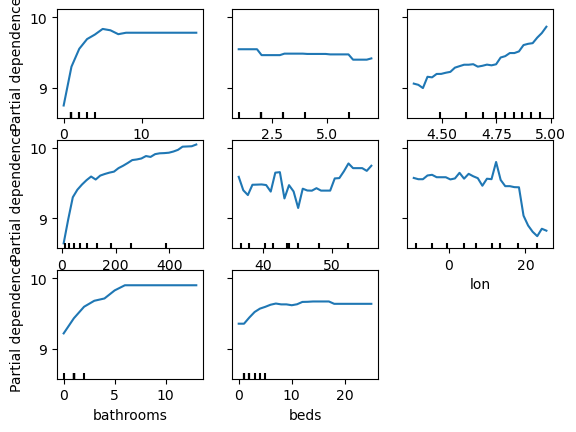

In [61]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Use raw X_train (NOT transformed — the pipeline handles that)
PartialDependenceDisplay.from_estimator(
    best_xgb_model,                # your full fitted pipeline
    X_train,                       # raw features with column names
    features=['rooms', 'min_nights', 'rating', 'num_reviews', 'lat', 'lon', 'bathrooms', 'beds'],  # any continuous feature names
    kind='average',
    grid_resolution=30
)
plt.show()




In [63]:
# Turn search results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Convert the score to positive MAE
results['mae'] = -results['mean_test_score']

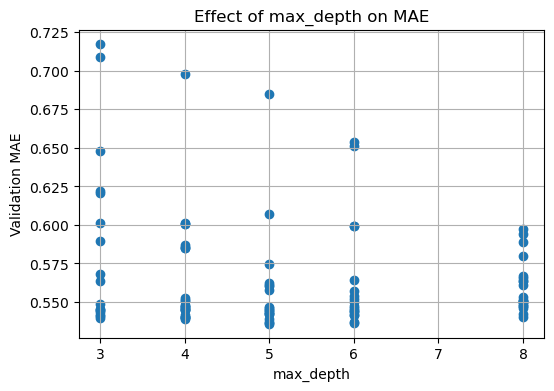

In [65]:
plt.figure(figsize=(6, 4))
plt.scatter(results['param_xgbregressor__max_depth'], results['mae'])
plt.xlabel('max_depth')
plt.ylabel('Validation MAE')
plt.title('Effect of max_depth on MAE')
plt.grid(True)
plt.show()



In [162]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess_guests,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model2 = random_search.best_estimator_

train_preds_log = best_xgb_model2.predict(X_train)
valid_preds_log = best_xgb_model2.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

2025-05-09 21:44:20,904 - INFO - Starting RandomizedSearchCV for XGBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 21:44:39,596 - INFO - XGBoost MAE on train set: 7718.58
2025-05-09 21:44:39,596 - INFO - XGBoost MAE on validation set: 8722.10
2025-05-09 21:44:39,597 - INFO - Best params: {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1.0, 'xgbregressor__reg_alpha': 1.0, 'xgbregressor__n_estimators': 400, 'xgbregressor__min_child_weight': 5, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0, 'xgbregressor__colsample_bytree': 1.0}


# HistGradientRegressor

## Baseline

In [65]:

hgb_model = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

logging.info("Fitting HistGradientBoostingRegressor...")
hgb_model.fit(X_train, y_train_log)


train_preds_log = hgb_model.predict(X_train)
valid_preds_log = hgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")

2025-05-09 17:47:10,221 - INFO - Fitting HistGradientBoostingRegressor...
2025-05-09 17:47:10,594 - INFO - HistGradientBoosting Train MAE: 8244.27
2025-05-09 17:47:10,594 - INFO - HistGradientBoosting Valid MAE: 8855.14


## HistGradient RandomSearch

In [101]:


# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid = {
    'histgradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300],
    'histgradientboostingregressor__max_depth': [None, 5, 10],
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 1.0]
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model.predict(X_train))
valid_preds = np.expm1(best_hgb_model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-05-09 18:05:40,606 - INFO - HistGradientBoosting Train MAE: 8147.52
2025-05-09 18:05:40,607 - INFO - HistGradientBoosting Valid MAE: 8812.80
2025-05-09 18:05:40,607 - INFO - Best params: {'histgradientboostingregressor__min_samples_leaf': 10, 'histgradientboostingregressor__max_iter': 300, 'histgradientboostingregressor__max_depth': 5, 'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__l2_regularization': 0.0}


## !Testing!

### Selected for voting 

In [94]:
# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess_guests,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid =  {
    'histgradientboostingregressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],  # like n_estimators
    'histgradientboostingregressor__max_depth': [None, 5, 10, 20],     # controls tree depth
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50, 100],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'histgradientboostingregressor__max_leaf_nodes': [15, 31, 63],     # cap on tree complexity
    'histgradientboostingregressor__early_stopping': [False],          # we control stopping manually
    'histgradientboostingregressor__scoring': [None],                  # uses loss, not validation metric
    'histgradientboostingregressor__monotonic_cst': [None],            # can later test constraints
    'histgradientboostingregressor__categorical_features': [None], 
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model1 = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model1.predict(X_train))
valid_preds = np.expm1(best_hgb_model1.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 19:57:48,897 - INFO - HistGradientBoosting Train MAE: 7502.00
2025-05-09 19:57:48,899 - INFO - HistGradientBoosting Valid MAE: 8741.81
2025-05-09 19:57:48,899 - INFO - Best params: {'histgradientboostingregressor__scoring': None, 'histgradientboostingregressor__monotonic_cst': None, 'histgradientboostingregressor__min_samples_leaf': 10, 'histgradientboostingregressor__max_leaf_nodes': 63, 'histgradientboostingregressor__max_iter': 500, 'histgradientboostingregressor__max_depth': 5, 'histgradientboostingregressor__learning_rate': 0.05, 'histgradientboostingregressor__l2_regularization': 0.1, 'histgradientboostingregressor__early_stopping': False, 'histgradientboostingregressor__categorical_features': None}


# Model Stacking

In [241]:
from sklearn.ensemble import StackingRegressor
stack = StackingRegressor(
    estimators=[
        ('gbr', best_gbr_model1),
        ('xgb', best_xgb_model1),
        ('hgr', best_hgb_model1),
        ('ridge', ridge_model),
        ('knn', best_knn_model)
    ],
    final_estimator=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=r_state)
)
stack.fit(X_train, y_train_log)


StackingRegressor(estimators=[('gbr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('lat',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer()),
                                                                                                 ('scaler',
                                                                                                  MinMaxScaler())]),
                                                                                 ['lat']),
                                                                                ('lon',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer()),
                                                                                                 ('scaler',
                                                                                                  MinMaxScaler())]),
                                                                                 ['lon']),
                                                                                ('rooms',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')...
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['room_type']),
                                                                                ('cancellation',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehot',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['cancellation'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(metric='manhattan',
                                                                    n_neighbors=15,
                                                                    weights='distance'))]))],
                  final_estimator=GradientBoostingRegressor(random_state=123))

In [243]:
# Predict log-transformed outputs
train_preds_log = stack.predict(X_train)
valid_preds_log = stack.predict(X_valid)

# Inverse transform to original scale
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate MAE
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"StackingRegressor Train MAE: {train_mae:.2f}")
print(f"StackingRegressor Valid MAE: {valid_mae:.2f}")

StackingRegressor Train MAE: 7499.93
StackingRegressor Valid MAE: 8701.89


# CatBoost

In [263]:
# pip install catboost ## Only run once
from catboost import CatBoostRegressor

# Define the pipeline
catboost_pipeline = make_pipeline(
    preprocess1,
    CatBoostRegressor(
        loss_function='RMSE',
        verbose=0,
        random_state=r_state
    )
)

# Define hyperparameter grid
param_grid = {
    'catboostregressor__iterations': [300, 500, 700, 1000],
    'catboostregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'catboostregressor__depth': [4, 6, 8, 10],
    'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 10],
    'catboostregressor__bootstrap_type': ['Bayesian', 'Bernoulli'],
    #'catboostregressor__bagging_temperature': [0, 1, 5, 10]
}

# Run RandomizedSearchCV
random_search_cat = RandomizedSearchCV(
    estimator=catboost_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for CatBoost...")
random_search_cat.fit(X_train, y_train_log)

# Get best model
best_cat_model = random_search_cat.best_estimator_

# Predict
train_preds_log = best_cat_model.predict(X_train)
valid_preds_log = best_cat_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"CatBoost Train MAE: {train_mae:.2f}")
logging.info(f"CatBoost Valid MAE: {valid_mae:.2f}")
logging.info(f"Best CatBoost Params: {random_search_cat.best_params_}")



2025-05-09 22:29:28,968 - INFO - Starting RandomizedSearchCV for CatBoost...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-09 22:37:05,967 - INFO - CatBoost Train MAE: 8466.12
2025-05-09 22:37:05,967 - INFO - CatBoost Valid MAE: 8752.48
2025-05-09 22:37:05,968 - INFO - Best CatBoost Params: {'catboostregressor__learning_rate': 0.1, 'catboostregressor__l2_leaf_reg': 10, 'catboostregressor__iterations': 1000, 'catboostregressor__depth': 4, 'catboostregressor__bootstrap_type': 'Bayesian'}


# LightGBM

In [261]:
# pip install lightgbm ## Only run once
from lightgbm import LGBMRegressor

# Define the pipeline
lgbm_pipeline = make_pipeline(
    preprocess_guests,
    LGBMRegressor(
        objective='regression',
        random_state=r_state,
        verbose=-1
    )
)

# Define hyperparameter grid
param_grid = {
    'lgbmregressor__n_estimators': [100, 200, 300, 500],
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'lgbmregressor__max_depth': [-1, 4, 6, 8, 10],
    'lgbmregressor__num_leaves': [15, 31, 63, 127],
    'lgbmregressor__min_child_samples': [5, 10, 20, 50],
    'lgbmregressor__subsample': [0.6, 0.8, 1.0],
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'lgbmregressor__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'lgbmregressor__reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Run RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for LightGBM...")
random_search_lgbm.fit(X_train, y_train_log)

# Best model
best_lgbm_model = random_search_lgbm.best_estimator_

# Predict
train_preds_log = best_lgbm_model.predict(X_train)
valid_preds_log = best_lgbm_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"LightGBM Train MAE: {train_mae:.2f}")
logging.info(f"LightGBM Valid MAE: {valid_mae:.2f}")
logging.info(f"Best LightGBM Params: {random_search_lgbm.best_params_}")



2025-05-09 22:26:52,547 - INFO - Starting RandomizedSearchCV for LightGBM...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-05-09 22:28:02,089 - INFO - LightGBM Train MAE: 6999.99
2025-05-09 22:28:02,089 - INFO - LightGBM Valid MAE: 8721.26
2025-05-09 22:28:02,090 - INFO - Best LightGBM Params: {'lgbmregressor__subsample': 1.0, 'lgbmregressor__reg_lambda': 0.5, 'lgbmregressor__reg_alpha': 0.1, 'lgbmregressor__num_leaves': 127, 'lgbmregressor__n_estimators': 500, 'lgbmregressor__min_child_samples': 10, 'lgbmregressor__max_depth': 6, 'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__colsample_bytree': 0.6}


In [259]:

# Define the pipeline
lgbm_pipeline = make_pipeline(
    preprocess1,
    LGBMRegressor(
        objective='regression',
        random_state=r_state,
        verbose=-1
    )
)

# Define hyperparameter grid
param_grid = {
    'lgbmregressor__n_estimators': [100, 200, 300, 500],
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'lgbmregressor__max_depth': [-1, 4, 6, 8, 10],
    'lgbmregressor__num_leaves': [15, 31, 63, 127],
    'lgbmregressor__min_child_samples': [5, 10, 20, 50],
    'lgbmregressor__subsample': [0.6, 0.8, 1.0],
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'lgbmregressor__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'lgbmregressor__reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Run RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for LightGBM...")
random_search_lgbm.fit(X_train, y_train_log)

# Best model
best_lgbm_model = random_search_lgbm.best_estimator_

# Predict
train_preds_log = best_lgbm_model.predict(X_train)
valid_preds_log = best_lgbm_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"LightGBM Train MAE: {train_mae:.2f}")
logging.info(f"LightGBM Valid MAE: {valid_mae:.2f}")
logging.info(f"Best LightGBM Params: {random_search_lgbm.best_params_}")



2025-05-09 22:25:26,469 - INFO - Starting RandomizedSearchCV for LightGBM...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-05-09 22:26:34,039 - INFO - LightGBM Train MAE: 7158.35
2025-05-09 22:26:34,040 - INFO - LightGBM Valid MAE: 8751.35
2025-05-09 22:26:34,040 - INFO - Best LightGBM Params: {'lgbmregressor__subsample': 1.0, 'lgbmregressor__reg_lambda': 0.5, 'lgbmregressor__reg_alpha': 0.1, 'lgbmregressor__num_leaves': 127, 'lgbmregressor__n_estimators': 500, 'lgbmregressor__min_child_samples': 10, 'lgbmregressor__max_depth': 6, 'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__colsample_bytree': 0.6}


# Voting Regressor

## Mixed features

In [266]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr_model1),
    ('xgb', best_xgb_model1),
    ('hgb', best_hgb_model1),
    ('lgbm', best_lgbm_model),
    ('cat', best_cat_model)
    #('ridge', ridge_model)
])
## Best model so far: validation MAE 8632

In [268]:
voting_model.fit(X_train, y_train_log)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('lat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lat']),
                                                                              ('lon',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lon']),
                                                                              ('rooms',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),...
                                                                                                                    validate=True)),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['beds']),
                                                                              ('room_type',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['room_type']),
                                                                              ('cancellation',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['cancellation'])])),
                                             ('catboostregressor',
                                              <catboost.core.CatBoostRegressor object at 0x00000248F6ACA960>)]))])

In [270]:
# Predict (log scale → exp transform)
train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")


C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\chels\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


VotingRegressor Train MAE: 7603.67
VotingRegressor Valid MAE: 8632.19


## All same features (all have guests column added in preprocessing)

In [168]:
# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr_model2),
    ('xgb', best_xgb_model2),
    ('hgb', best_hgb_model1)
])

In [170]:
voting_model.fit(X_train, y_train_log)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('lat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lat']),
                                                                              ('lon',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lon']),
                                                                              ('rooms',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['cancellation'])])),
                                             ('histgradientboostingregressor',
                                              HistGradientBoostingRegressor(categorical_features=None,
                                                                            early_stopping=False,
                                                                            l2_regularization=0.1,
                                                                            learning_rate=0.05,
                                                                            max_depth=5,
                                                                            max_iter=500,
                                                                            max_leaf_nodes=63,
                                                                            min_samples_leaf=10,
                                                                            random_state=123,
                                                                            scoring=None))]))])

In [172]:
# Predict (log scale → exp transform)
train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")


VotingRegressor Train MAE: 7531.52
VotingRegressor Valid MAE: 8679.83


## Different imputation methods

In [205]:
# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr_model1),
    ('xgb', best_xgb_model1),
    ('hgb', best_hgb_model1),
    ('knn', best_knn_model),
    ('ridge',ridge_model)
])

In [207]:
voting_model.fit(X_train, y_train_log)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('lat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lat']),
                                                                              ('lon',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['lon']),
                                                                              ('rooms',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),...
                                                                                                FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                    validate=True)),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['guests']),
                                                                              ('room_type',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['room_type']),
                                                                              ('cancellation',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['cancellation'])])),
                                             ('ridge',
                                              Ridge(alpha=1,
                                                    random_state=123))]))])

In [209]:
# Predict (log scale → exp transform)
train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")

VotingRegressor Train MAE: 6738.59
VotingRegressor Valid MAE: 8987.19
